In [50]:
import sys
import random
import hashlib
import cupy as cp 
import numpy as np
import numpy.linalg as LA
from os.path import abspath, join
sys.path.append(abspath(join('../..')))
sys.path.append(abspath(join('..')))

import copy
from math import pi
from os.path import expanduser, join
from Libs import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from LevelSetPy.Grids import *
from LevelSetPy.Utilities import *
from LevelSetPy.Visualization import *
from LevelSetPy.BoundaryCondition import *
from LevelSetPy.DynamicalSystems import *
from LevelSetPy.InitialConditions import *

# from LevelSetPy.SpatialDerivative import upwindFirstENO2
# from LevelSetPy.ExplicitIntegration.Integration import odeCFL2, odeCFLset
# from LevelSetPy.ExplicitIntegration.Dissipation import artificialDissipationGLF
from BRATVisualization.rcbrt_visu import RCBRTVisualizer
from Utilities.visualizations import visualize_init_avoid_tube
from LevelSetPy.ExplicitIntegration.Term import termRestrictUpdate, termLaxFriedrichs
%matplotlib inline

In [51]:
args = Bundle(dict(visualize=True, show_flock_payoff=True))

In [52]:

def visualize_init_avoid_tube(flock, save=True, fname=None, title=''):
	"""
		For a flock, whose mesh has been precomputed, 
		visualize the initial backward avoid tube.
	"""
	# visualize avoid set 
	fontdict = {'fontsize':16, 'fontweight':'bold'}
	mesh_bundle = flock.mesh_bundle
		
	fig = plt.figure(1, figsize=(16,9), dpi=100)
	ax = plt.subplot(111, projection='3d')
	ax.add_collection3d(mesh_bundle.mesh)


	xlim = (mesh_bundle.verts[:, 0].min(), mesh_bundle.verts[:,0].max())
	ylim = (mesh_bundle.verts[:, 1].min(), mesh_bundle.verts[:,1].max())
	zlim = (mesh_bundle.verts[:, 2].min(), mesh_bundle.verts[:,2].max())

	# create grid that contains just this zero-level set to avoid computational craze 
	gmin = np.asarray([[xlim[0], ylim[0], zlim[0]]]).T
	gmax = np.asarray([[xlim[1], ylim[1], zlim[1]]]).T

	# create reduced grid upon which this zero level set dwells
	flock.grid_zero = createGrid(gmin, gmax, flock.grid.N, 2)

	ax.set_xlim(xlim)
	ax.set_ylim(ylim)
	ax.set_zlim(zlim)

	ax.grid('on')
	ax.tick_params(axis='both', which='major', labelsize=10)

	ax.set_xlabel(rf'x$_1^{flock.label}$ (m)', fontdict=fontdict)
	ax.set_ylabel(rf'x$_2^{flock.label}$ (m)', fontdict=fontdict)
	ax.set_zlabel(rf'$\omega^{flock.label} (rad)$',fontdict=fontdict)

	if title:
		ax.set_title(title, fontdict=fontdict)
	else:
		ax.set_title(f'Flock {flock.label}\'s ({flock.N} Agents) Payoff.', fontdict=fontdict)
	ax.view_init(azim=-45, elev=30)

	if save:
		plt.savefig(fname, bbox_inches='tight',facecolor='None')


def get_avoid_brt(flock, compute_mesh=True, color='crimson'):
	"""
		Get the avoid BRT for this flock. That is, every bird 
		within a flock must avoid one another.

		Parameters:
		==========
		.flock: This flock of vehicles.
		.compute_mesh: compute mesh of local payoffs for each bird in this flock?
		.color: Face color of this mesh.
	"""
	for vehicle in flock.vehicles:
		# make the radius of the target setthe turn radius of this vehicle
		vehicle.payoff = shapeCylinder(flock.grid, 2, center=flock.position(vehicle.cur_state), \
										radius=vehicle.payoff_width)
	"""
		Now compute the overall payoff for the flock
	   	by taking a union of all the avoid sets.
	"""
	flock.payoff = shapeUnion([veh.payoff for veh in flock.vehicles])
	if compute_mesh:
		spacing=tuple(flock.grid.dx.flatten().tolist())
		flock.mesh_bundle = implicit_mesh(flock.payoff, 0, spacing,edge_color=None, face_color=color)    
		
	return flock 

u_bound = 1
w_bound = 1 #deg2rad(45)

def get_flock(gmin, gmax, num_points, num_agents, init_xyzs, label,\
				periodic_dims=2, reach_rad=.2, avoid_rad=.3,
				base_path='', save=True, color='blue'):
	"""
		Params
		======
		gmin: minimum bounds of the grid
		gmax: maximum bounds of the grid
		num_points: number of points on the grid
		num_agents: number of agents in this flock
		init_xyzs: initial positions of the birds in this flock
		label: label of this flock among all flocks
		periodic_dims: periodic dimensions
		reach_rad: reach for external disturbance
		avoid_rad: avoid radius for topological interactions
	"""
	global u_bound, w_bound

	assert gmin.ndim==2, 'gmin must be of at least 2 dims'
	assert gmax.ndim==2, 'gmax must be of at least 2 dims'

	gmin = to_column_mat(gmin)
	gmax = to_column_mat(gmax)

	grid = createGrid(gmin, gmax, num_points, periodic_dims)
	
	vehicles = [Bird(grid, u_bound, w_bound, np.expand_dims(init_xyzs[i], 1) , random.random(), \
					center=np.zeros((3,1)), neigh_rad=3, label=i+1, init_random=False) \
					for i in range(num_agents)]                
	flock = Flock(grid, vehicles, label=label, reach_rad=.2, avoid_rad=.3)
	get_avoid_brt(flock, compute_mesh=True, color=color)

	if args.visualize and args.show_flock_payoff:
		visualize_init_avoid_tube(flock, save, fname=join(base_path, f"flock_{flock.label}.jpg"))         
		plt.show() 

	return flock

In [53]:
gmin = np.asarray([[-1.5, -1.5, -np.pi]]).T
gmax = np.asarray([[1.5, 1.5, np.pi] ]).T
num_agents = 7

H         = 0.4
H_STEP    = 0.05
neigh_rad = 0.4
reach_rad = .2

# Please note the way I formulate the initial states here. Linear speed is constant but heading is different.
INIT_XYZS = np.array([[neigh_rad*np.cos((i/6)*np.pi/4), neigh_rad*np.sin((i/6)*np.pi/4), H+i*H_STEP] for i in range(num_agents)])

# color thing
color = iter(plt.cm.inferno_r(np.linspace(0, 1, num_agents)))

# save shenanigans
base_path = join(expanduser("~"), "Documents/Papers/Safety/WAFR2022/figures")
flock0 = get_flock(gmin, gmax, 101, num_agents, INIT_XYZS, label=1, periodic_dims=2, \
                    reach_rad=.2, avoid_rad=.3, base_path=base_path, color=next(color))	
flock1 = get_flock(gmin, gmax, 101, num_agents-1, 1.1*INIT_XYZS, label=2,\
                    periodic_dims=2, reach_rad=.2, avoid_rad=.3, base_path=base_path, color=next(color))	           
flock2 = get_flock(gmin, gmax, 101, num_agents, -1.1*INIT_XYZS, label=3,\
                    periodic_dims=2, reach_rad=.2, avoid_rad=.3, base_path=base_path, color=next(color))	                         
flock3 = get_flock(gmin, gmax, 101, num_agents-1, 1.5*INIT_XYZS, label=4,\
                    periodic_dims=2, reach_rad=.2, avoid_rad=.3, base_path=base_path, color=next(color))	                             
flock4 = get_flock(gmin, gmax, 101, num_agents, -1.5*INIT_XYZS, label=5,\
                    periodic_dims=2, reach_rad=.2, avoid_rad=.3, base_path=base_path, color=next(color))	                
flock5 = get_flock(gmin, gmax, 101, num_agents-1, 2.0*INIT_XYZS, label=6,\
                    periodic_dims=2, reach_rad=.2, avoid_rad=.3, base_path=base_path, color=next(color))	          
flock6 = get_flock(gmin, gmax, 101, num_agents, -1.8*INIT_XYZS, label=7,\
                    periodic_dims=2, reach_rad=.2, avoid_rad=.3, base_path=base_path, color=next(color))	

AttributeError: 'Flock' object has no attribute 'position'

In [54]:
# after creating value function, make state space cupy objects
g = flock0.grid
spacing=tuple(flock0.grid.dx.flatten().tolist())

# after creating value function, make state space cupy objects
g.xs = [cp.asarray(x) for x in g.xs]
finite_diff_data = Bundle(dict(innerFunc = termLaxFriedrichs,
            innerData = Bundle({'grid':g,
                'hamFunc': flock0.hamiltonian,
                'partialFunc': flock0.dissipation,
                'dissFunc': artificialDissipationGLF,
                'CoStateCalc': upwindFirstENO2,
                }),
                positive = False,  # direction to grow the updated level set
            ))

t_range = [0, 2.5]

params = Bundle(
                {"grid": g,
                    'disp': True,
                    'labelsize': 16,
                    'labels': "Initial 0-LevelSet",
                    'linewidth': 2,
                    'elevation': 10,
                    'azimuth': 5,
                    'mesh': flock0.mesh_bundle,
                    'pause_time': .3,
                    'title': f'Flock {flock0.label}\'s Avoid Tube. Num Agents={flock0.N}',
                    'level': 0, # which level set to visualize
                    'winsize': (16,9),
                    'fontdict': {'fontsize':18, 'fontweight':'bold'},
                    "savedict": Bundle({"save": True,
                                "savename": "murmur",
                                "savepath": join(expanduser("~"),
                                "Documents/Papers/Safety/WAFR2022/figures/")
                                })
                }
                )

NameError: name 'flock0' is not defined

In [ ]:
# viz = RCBRTVisualizer(params=params)
t_plot = (t_range[1] - t_range[0]) / 10
small = 100*eps
options = Bundle(dict(factorCFL=0.95, stats='on', singleStep='off'))

# Loop through t_range (subject to a little roundoff).
t_now = t_range[0]
start_time = cputime()
itr_start = cp.cuda.Event()
itr_end = cp.cuda.Event()

brt = [flock0.payoff]
meshes, brt_time = [], []
value_rolling = cp.asarray(copy.copy(flock0.payoff))

In [ ]:
save = True

while(t_range[1] - t_now > small * t_range[1]):
	itr_start.record()
	cpu_start = cputime()
	time_step = f"{t_now}/{t_range[-1]}"

	# Reshape data array into column vector for ode solver call.
	y0 = value_rolling.flatten()

	# How far to step?
	t_span = np.hstack([ t_now, min(t_range[1], t_now + t_plot) ])

	# Integrate a timestep.
	t, y, _ = odeCFL2(termRestrictUpdate, t_span, y0, odeCFLset(options), finite_diff_data)
	cp.cuda.Stream.null.synchronize()
	t_now = t

	# Get back the correctly shaped data array
	value_rolling = y.reshape(g.shape)

	value_rolling_np = value_rolling.get()
	mesh=implicit_mesh(value_rolling_np, level=0, spacing=spacing,
						edge_color=None,  face_color='orange')
	# viz.update_tube(mesh_bundle, time_step)
	# store this brt
	brt.append(value_rolling_np); brt_time.append(t_now); meshes.append(mesh)

	if save:
		fig = plt.gcf()
		fig.savefig(join(expanduser("~"),"Documents/Papers/Safety/WAFR2022",
			rf"figures/rcbrt_{t_now}.jpg"),
			bbox_inches='tight',facecolor='None')

	itr_end.record()
	itr_end.synchronize()
	cpu_end = cputime()

	info(f't: {time_step} | GPU time: {(cp.cuda.get_elapsed_time(itr_start, itr_end)):.2f} | CPU Time: {(cpu_end-cpu_start):.2f}, | Targ bnds {min(y):.2f}/{max(y):.2f} Norm: {np.linalg.norm(y, 2):.2f}')


In [ ]:
def controllability(g, gr, attr, value_func_init):
	fontdict = {'fontsize':28, 'fontweight':'bold'}
	f, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))

	ax1.contour(g.xs[0], g.xs[1], attr, colors='red')
	ax1.set_title('Analytical TTR', fontdict =fontdict)
	ax1.set_xlabel(r"$x_1 (m)$", fontdict =fontdict)
	ax1.set_ylabel(r"$x_2 (ms^{-1})$", fontdict =fontdict)
	ax1.tick_params(axis='both', which='major', labelsize=28)
	ax1.tick_params(axis='both', which='minor', labelsize=18)
	ax1.set_xlim([-1.02, 1.02])
	ax1.set_ylim([-1.01, 1.01])
	ax1.grid()

	ax2.contour(gr.xs[0], gr.xs[1], value_func_init, colors='blue')
	ax2.set_title('Numerical TTR', fontdict =fontdict)
	ax2.set_xlabel(r"$x_1 (m)$", fontdict =fontdict)
	ax2.set_xlim([-1.02, 1.02])
	ax2.set_ylim([-1.01, 1.01])
	ax2.grid('on')
	ax2.tick_params(axis='both', which='major', labelsize=28)
	ax2.tick_params(axis='both', which='minor', labelsize=18)
	ax2.legend(loc="center left", fontsize=8) 

	f.suptitle(f"Levelsets")

	f.canvas.draw()
	f.canvas.flush_events()
	time.sleep(args.pause_time)

In [ ]:
g.xs = [g.xs[i].get() for i in range(g.dim)]
gr.xs = [gr.xs[i].get() for i in range(gr.dim)]
view_noncontrollability(g, gr, attr, value_rob)

In [ ]:
gs

In [ ]:
p1, p2, mode= obj.p1.pursuer, obj.p1.evader, 'capture'

assert isfield(p1, 'center'), 'player I must have a center '\
                                'defined for its capture equation.'
assert isfield(p2, 'center'), 'player II must have a center '\
                                'defined for its capture equation.'
assert isfield(p1, 'grid'), 'player I must have its grid info'
assert isfield(p2, 'grid'), 'player II must have its grid info'

x1 = p1.grid.xs
x2 = p2.grid.xs

p1_dyn  = cell(3)
p2_dyn = cell(3)

p1_dyn[0] = obj.vp*np.cos(x1[2])
p1_dyn[1] = obj.vp*np.sin(x1[2])
p1_dyn[2] = obj.we

p2_dyn[0] = obj.ve*np.cos(x2[2])
p2_dyn[1] = obj.ve*np.sin(x2[2])
p2_dyn[2] = obj.wp

data_agent1 = np.zeros(p1.grid.shape)
data_agent2 = np.zeros(p2.grid.shape)

if isfield(p1, 'center') and numel(p1.center==1):
    p1.center = p1.center*np.ones((p1.grid.dim,1), dtype=np.float64)
if isfield(p2, 'center') and numel(p2.center==1):
    p2.center = p2.center*np.ones((p2.grid.dim,1), dtype=np.float64)
        

### Load the BRATSs from a previous iteration

CUDARuntimeError: cudaErrorUnknown: unknown error

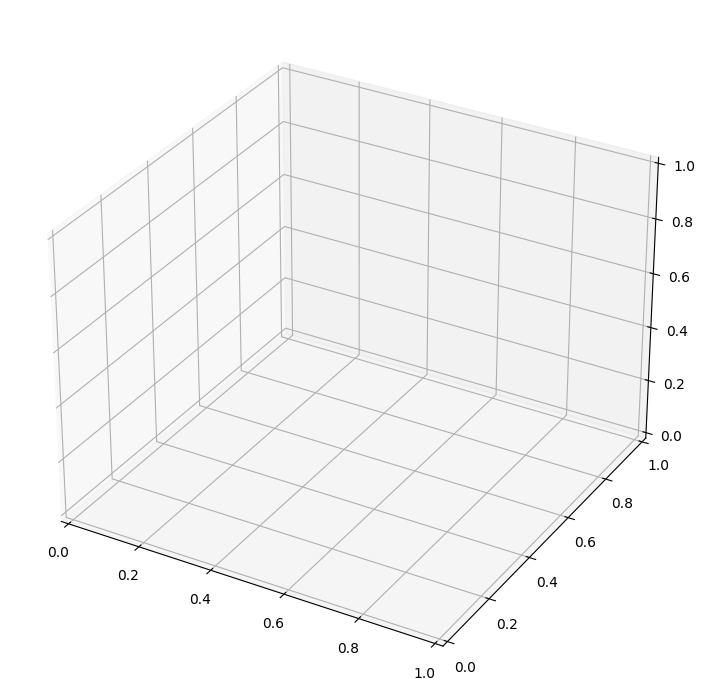

In [58]:
import h5py
import time
import matplotlib.pyplot as plt

# recreate spacing

gmin = np.asarray([[-1.5, -1.5, -np.pi]]).T
gmax = np.asarray([[1.5, 1.5, np.pi] ]).T
grid = createGrid(gmin, gmax, 101, 2)
spacing = tuple(grid.dx.flatten().tolist())

def see(n, obj):
    keys = []
    for k, v in obj.attrs.items():
        #print(k, v)  
        keys.append((k,v))
    return keys

verbose = False
fname = '../data/murmurations_flock1_02-04-22_00-35.hdf5'


fontdict = {'fontsize':16, 'fontweight':'bold'}

plt.ion()
fig = plt.figure(1, figsize=(16,9), dpi=100)
ax = plt.subplot(111, projection='3d')

with h5py.File(fname, 'r+') as df:
    if verbose:
        df.visititems(see)
    
    value_key = [k for k in df.keys()][0]
    keys = [key for key in df[value_key]]

    # load them brats for a flock
    colors = iter(plt.cm.turbo(np.linspace(0, len(keys), len(keys))))
    for key in keys:
        brt = np.asarray(df[f"{value_key}/{key}"])
        brt_cp = cp.asarray(brt)
        print(brt_cp.shape, type(brt_cp))

        mesh_bundle=implicit_mesh(brt, level=0, spacing=spacing,
                                edge_color=None,  face_color=next(colors))

        ax.grid('on')
        plt.cla()

        ax.add_collection3d(mesh_bundle.mesh)
        xlim = (mesh_bundle.verts[:, 0].min(), mesh_bundle.verts[:,0].max())
        ylim = (mesh_bundle.verts[:, 1].min(), mesh_bundle.verts[:,1].max())
        zlim = (mesh_bundle.verts[:, 2].min(), mesh_bundle.verts[:,2].max())

        ax.set_xlim3d(*xlim)
        ax.set_ylim3d(*ylim)
        ax.set_zlim3d(*zlim)

        ax.tick_params(axis='both', which='major', labelsize=10)

        ax.set_xlabel(rf'x$_1^{1}$ (m)', fontdict=fontdict)
        ax.set_ylabel(rf'x$_2^{1}$ (m)', fontdict=fontdict)
        ax.set_zlabel(rf'$\omega^{1} (rad)$',fontdict=fontdict)

        ax.set_title(f'BRT at {key} secs.', fontdict=fontdict)
        ax.view_init(azim=-30, elev=30)

        fig.canvas.draw()
        fig.canvas.flush_events()

        time.sleep(.3)
        
        break 

plt.ioff()

In [47]:
blue_color = plt.get_cmap("Blues")

TypeError: 'LinearSegmentedColormap' object is not an iterator

In [48]:
help(np.random.choice)

Help on built-in function choice:

choice(...) method of numpy.random.mtrand.RandomState instance
    choice(a, size=None, replace=True, p=None)
    
    Generates a random sample from a given 1-D array
    
    .. versionadded:: 1.7.0
    
    .. note::
        New code should use the ``choice`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    a : 1-D array-like or int
        If an ndarray, a random sample is generated from its elements.
        If an int, the random sample is generated as if it were ``np.arange(a)``
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    replace : boolean, optional
        Whether the sample is with or without replacement. Default is True,
        meaning that a value of ``a`` can be selected mu

In [49]:
a = range(5, 10)
np.random.choice(a)

5